In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import bayesoptlib as BO


In [2]:
def hex(u,Th1,Th2):
    '''
    - Simple Parallel heat exchanger model with two Heat exchangers
    - Steady-state model
    - Jäschke, J. and Skogestad, S., 2014. Optimal operation of heat exchanger networks with stream split: Only temperature measurements are required. Computers & chemical engineering, 70, pp.35-49.
    '''
    T0 = 60
    w0 = 100 
    wh1 = 30
    wh2 = 50
    UA1 = 50
    UA2 = 80

    T1 = T0 + (Th1-T0)/(1/2+u*w0*(1/(2*wh1)+1/UA1))
    T2 = T0 + (Th2-T0)/(1/2+(1-u)*w0*(1/(2*wh2)+1/UA2))
    
    T = u*T1 + (1-u)*T2

    Th1e = Th1 - u*w0/wh1*(T1 - T0)
    Th2e = Th2 - (1-u)*w0/wh2*(T2 - T0)

    return T,T1,T2


inputDim = 4

x = 0.4



T,T1,T2 = hex(x,Th1=120,Th2=150)
print(T,T1,T2)

def mid_selector(a, b, c):
    # Directly compare the values to find the median
    if (a <= b and b <= c) or (c <= b and b <= a):
        return b  # b is the middle value
    elif (b <= a and a <= c) or (c <= a and a <= b):
        return a  # a is the middle value
    else:
        return c  # c is the middle value


101.39257901969765 90.50847457627118 108.64864864864865


In [3]:
from scipy.optimize import minimize

# Objective function to maximize T; negative sign because we use minimize()
def objective(u, Th1, Th2):
    T, _, _ = hex(u, Th1, Th2)
    return -T  

# Constraints that T1 and T2 must be less than 125
def constraint1(u, Th1, Th2):
    _, T1, _ = hex(u, Th1, Th2)
    return 125 - T1  # T1 must be less than 125

def constraint2(u, Th1, Th2):
    _, _, T2 = hex(u, Th1, Th2)
    return 125 - T2  # T2 must be less than 125

# Function to perform the optimization
def optimize_hex(Th1, Th2):
    # Initial guess for u
    initial_guess = [1.0]
    
    # Define the constraints
    constraints = [
        {'type': 'ineq', 'fun': constraint1, 'args': (Th1, Th2)},
        {'type': 'ineq', 'fun': constraint2, 'args': (Th1, Th2)}
    ]
    
    # Bounds for u (e.g., u should be non-negative)
    bounds = [(0, None)]
    
    # Perform the optimization
    result = minimize(objective, initial_guess, args=(Th1, Th2), bounds=bounds, constraints=constraints, method='SLSQP')
    
    # Extract the optimal values
    u_opt = result.x[0]
    T_opt, T1_opt, T2_opt = hex(u_opt, Th1, Th2)
    
    return {
        'u_opt': u_opt,
        'T_opt': T_opt,
        'T1_opt': T1_opt,
        'T2_opt': T2_opt,
        'success': result.success,
        'message': result.message
    }

# ideal optimum
Th1 = 120  # Disturbance 1
Th2 = 150  # Disturbance 2
optimal_solution = optimize_hex(Th1, Th2)
print(optimal_solution)
Jopt = 101.622

{'u_opt': 0.31712339445048837, 'T_opt': 101.62218358788746, 'T1_opt': 96.08402280933916, 'T2_opt': 104.19406894877562, 'success': True, 'message': 'Optimization terminated successfully'}


In [4]:

x = 0.5
x1 = x
x2 = x
T1sp = 125
T2sp = 125

for i in range(30):
    x1 = x1 - 0.003*(T1sp-T1)
    x1 = max(0, min(1, x1))
    x2 = x2 + 0.003*(T2sp-T2)
    x2 = max(0, min(1, x2))
    x = mid_selector(x1, x2, 0.5)
    T,T1,T2 = hex(x,Th1,Th2)

print(T,T1,T2,x,x1,x2)


100.54945054945055 85.71428571428572 115.38461538461539 0.5 0 1


In [50]:
Z_sample = np.array([x]).reshape(-1,1)
ZD_sample = np.concatenate((Z_sample,np.array(Th1).reshape(-1,1),np.array(Th2).reshape(-1,1)),axis=1)
J_sample = np.array(-T).reshape(1,1) # Cost

var0 = 50
kernel_f = GPy.kern.RBF(3,ARD = True, lengthscale=[0.5,5,5],variance=var0) #+ GPy.kern.Bias(inputDim) 
bounds = np.array([[0,1]]) # bounds for Fb


U_range = np.linspace(bounds[:, 0].T, bounds[:, 1].T, 1000).reshape(1000,-1)


Jt = []
y1t = []
y2t = []
y1spt = []
y2spt = []
xt = []
Pt = []
Joptt = []
Th1t = []
Th2t = []
x0t = []

nIter = 100
for sim_k in range(nIter):
    Th1 = 120 + 0.25*np.random.randn(1)  # Disturbance 1
    Th2 = 150 + 0.25*np.random.randn(1) # Disturbance 2
    Jopt = 101.622
    if sim_k>= 40:
        Th1 = 100 + 0.25*np.random.randn(1)
        Th2 = 220 + 0.25*np.random.randn(1)
        Jopt = 121.95 # ideal optimum for this disturbance, used for plotting
    if sim_k>=60:
        Th1 = 220 + 0.25*np.random.randn(1)
        Th2 = 130 + 0.25*np.random.randn(1)
        Jopt = 115.82  # ideal optimum for this disturbance, used for plotting
        
    Context = np.array([Th1,Th2]).reshape(-1,2)
    J_Obj = BO.contextual_bayesian_optimization(ZD_sample,J_sample,
                                                Context,bounds,kernel_f, X_grid = U_range)

    # Update the posterior
    J_Obj.fit_gp()
    if sim_k>=200:
       J_Obj.optimize_fit()
    J_Obj.query_next('UCB')

    x_opt = J_Obj.X_next[0][0]
    


    # system query
    Tsteps = 15
    e10 = 0
    e20 = 0
    for j in range(Tsteps):
        
        e1 = T1sp-T1
        e2 = T2sp-T2
        x1 = x1 - 0.004*(e1) - 0.05*(e1-e10)
        
        x1 = max(0, min(1, x1))
        x2 = x2 + 0.004*(e2) + 0.05*(e2-e20)

        x2 = max(0, min(1, x2))
        x = mid_selector(x1,x2,x_opt)

        e10 = e1
        e20 = e2
        
        T0 = T
        T10 = T1
        T20 = T2
        T,T1,T2 = hex(x,Th1,Th2)
        T= 0.1*T + 0.9*T0 + 0.25*np.random.randn(1)
        T1= 0.1*T1 + 0.9*T10 + 0.25*np.random.randn(1)
        T2= 0.1*T2 + 0.9*T20  + 0.25*np.random.randn(1)   
    
        Jt.append(T)
        y1t.append(T1)
        y2t.append(T2)
        xt.append(x)
        y1spt.append(T1sp)
        y2spt.append(T2sp)
        Joptt.append(Jopt)
        Th1t.append(Th1)
        Th2t.append(Th2)
        x0t.append(x_opt)

    x1 = x
    x2 = x
    
    Z_sample = np.vstack((Z_sample, x_opt))
    
    ZD_sample = np.vstack((ZD_sample, J_Obj.X_next))
    J_sample = np.vstack((J_sample, -T))
    
print(T,T1,T2,x)

[116.09164499] [124.99190388] [105.09046314] [0.55381071]


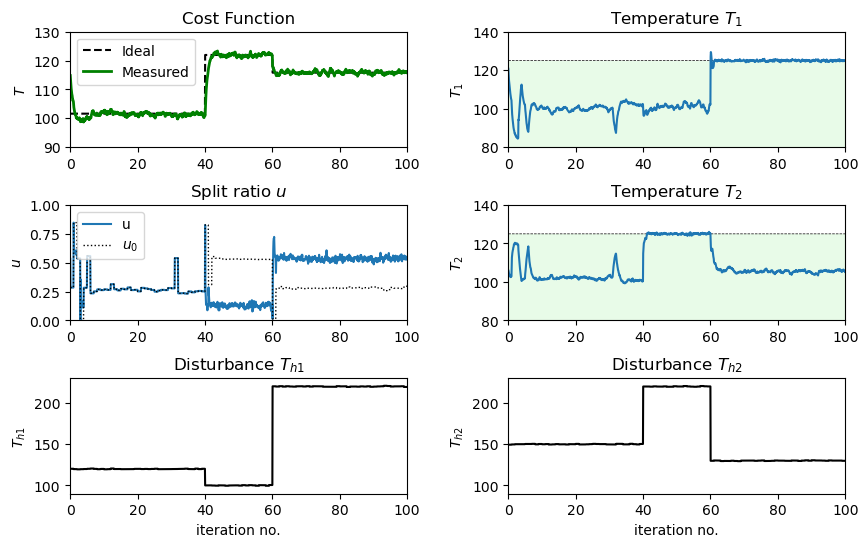

In [52]:
import matplotlib.gridspec as gridspec
# Create a 2x2 plot layout with each subplot 3x longer than tall
fig = plt.figure(figsize=(10, 6))  # Aspect ratio of 3x1 for each subplot
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(spec[0, 0])  # Top-left
ax2 = fig.add_subplot(spec[0, 1])  # Top-right
ax4 = fig.add_subplot(spec[1, 0])  # Bottom-left
ax3 = fig.add_subplot(spec[1, 1])  # Bottom-right
ax5 = fig.add_subplot(spec[2, 0])  # Bottom-left
ax6 = fig.add_subplot(spec[2, 1])  # Bottom-left

iter = np.linspace(0,100,nIter*Tsteps)
# First subplot
ax1.plot(iter,Joptt, 'k--', linewidth=1.5, label='Ideal')
ax1.plot(iter,Jt, 'g', linewidth=2, label='Measured')
ax1.set_ylabel('$T$')
ax1.set_xlim([0, 100])
ax1.set_ylim([90, 130])
ax1.legend()
ax1.set_title('Cost Function')

# Second subplot
ax2.plot(iter,y1spt, 'k--', linewidth=0.5)
ax2.plot(iter,y1t, linewidth=1.5)
ax2.set_ylabel('$T_1$')
ax2.set_ylim([80, 140])
ax2.set_xlim([0, 100])
#ax2.set_yticks([-8, -4, 0, 4])
ax2.axhspan(0, 125, facecolor='lightgreen', alpha=0.2)
ax2.set_title('Temperature $T_1$')

# Third subplot (Bottom-left)
ax3.plot(iter,y2spt, 'k--', linewidth=0.5)
ax3.plot(iter,y2t, linewidth=1.5)
ax3.set_ylabel('$T_2$')
ax3.set_ylim([80, 140])
ax3.set_xlim([0, 100])
#ax3.set_yticks([-8, -4, 0, 4])
ax3.axhspan(0, 125, facecolor='lightgreen', alpha=0.2)
ax3.set_title('Temperature $T_2$ ')

# Fourth subplot (Bottom-right)
xt = np.asarray(xt, dtype="object")
ax4.plot(iter,xt, linewidth=1.5,label='u')
ax4.plot(iter,x0t, 'k:',linewidth=1,label='$u_0$')
ax4.set_ylabel('$u$')
ax4.set_ylim([0, 1])
ax4.set_xlim([0, 100])
ax4.set_title('Split ratio $u$')
ax4.legend()

ax5.plot(iter,Th1t, 'k', linewidth=1.5,label='u')
ax5.set_ylabel('$T_{h1}$')
ax5.set_ylim([90, 230])
ax5.set_xlim([0, 100])
ax5.set_xlabel('iteration no.')
ax5.set_title('Disturbance $T_{h1}$')

ax6.plot(iter,Th2t, 'k', linewidth=1.5,label='u')
ax6.set_ylabel('$T_{h2}$')
ax6.set_ylim([90, 230])
ax6.set_xlim([0, 100])
ax6.set_xlabel('iteration no.')
ax6.set_title('Disturbance $T_{h2}$')
fig.savefig('Ex3_ts.pdf',bbox_inches='tight')
# Display the plot
plt.show()